# Final Models

## Loading and reshaping the data

In [1]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

import pandas as pd
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential



In [2]:
#load train data
x_train = pd.read_csv('x_train_full.csv')
y_train = pd.read_csv('y_train_full.csv')

In [3]:
#remove unecessary columns
x_train = x_train.iloc[:, 1:16385]
y_train = y_train.iloc[:, 1:2]

In [4]:
#load test data
x_test = pd.read_csv('x_test_full.csv')
y_test = pd.read_csv('y_test_full.csv')

In [5]:
#remove unecessary columns
x_test = x_test.iloc[:, 1:16385]
y_test = y_test.iloc[:, 1:2]

In [6]:
#reshape x-train and x-test
x_train = x_train.values.reshape(5216,128,128,1)
x_test = x_test.values.reshape(624, 128, 128, 1)

## Data Augmentation

In [7]:
#data augmentation

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

Using TensorFlow backend.


## Modelling

### Two-Layer Model

In [8]:
#load simple Neural Network -Model 1

model_one = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (128,128,1)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [9]:
#compile model
model_one.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [10]:
history = model_one.fit(x_train, y_train, 
      steps_per_epoch = 8,
      epochs=50,            
      verbose=1,
      validation_data = (x_test, y_test),
      validation_steps = 8)

# convert the history.history dict to a pandas DataFrame:     
hist_one_df = pd.DataFrame(history.history) 
hist_one_df.to_csv('history_one.csv', index=False)

Epoch 1/50
8/8 [==============================] - 2s 146ms/step - loss: 5.6337 - accuracy: 0.5540 - val_loss: 0.8794 - val_accuracy: 0.6250
Epoch 2/50
8/8 [==============================] - 1s 86ms/step - loss: 1.3272 - accuracy: 0.7200 - val_loss: 0.7062 - val_accuracy: 0.6875
Epoch 3/50
8/8 [==============================] - 1s 94ms/step - loss: 0.5570 - accuracy: 0.7822 - val_loss: 0.9721 - val_accuracy: 0.6522
Epoch 4/50
8/8 [==============================] - 1s 90ms/step - loss: 0.4003 - accuracy: 0.8278 - val_loss: 0.7974 - val_accuracy: 0.6827
Epoch 5/50
8/8 [==============================] - 1s 105ms/step - loss: 0.3039 - accuracy: 0.8684 - val_loss: 0.7000 - val_accuracy: 0.7131
Epoch 6/50
8/8 [==============================] - 1s 103ms/step - loss: 0.2492 - accuracy: 0.8921 - val_loss: 0.5023 - val_accuracy: 0.7708
Epoch 7/50
8/8 [==============================] - 1s 93ms/step - loss: 0.2217 - accuracy: 0.9118 - val_loss: 0.4675 - val_accuracy: 0.7804
Epoch 8/50
8/8 [========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


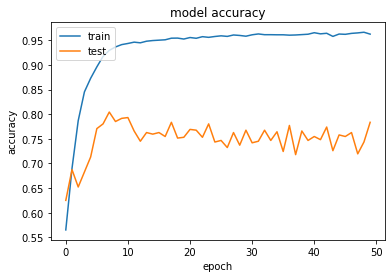

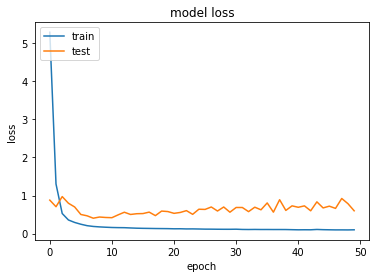

In [11]:
import matplotlib.pyplot as plt

print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Create a function to evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# Print the Evaluation metrics
prediction= model_one.predict_classes(x_test)
prediction = (model_one.predict(x_test) > 0.5).astype("int32")
print(classification_report(prediction, y_test))

# Print the confusion matrix values
print(confusion_matrix(prediction, y_test))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.45      0.94      0.61       113
           1       0.98      0.75      0.85       511

    accuracy                           0.78       624
   macro avg       0.72      0.84      0.73       624
weighted avg       0.89      0.78      0.81       624

[[106   7]
 [128 383]]


### Seven-Layer Model

In [13]:
#load second model

model_two = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 1)),
                                    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])

In [14]:
model_two.compile(optimizer = tf.optimizers.RMSprop(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model_two.fit(x_train, y_train, 
      batch_size = 200,
      epochs=50,            
      verbose=1,
      validation_data = (x_test, y_test))

# convert the history.history dict to a pandas DataFrame:     
hist_two_df = pd.DataFrame(history.history) 
hist_two_df.to_csv('history_two.csv', index=False)

Epoch 1/50
27/27 [==============================] - 22s 778ms/step - loss: 2.1275 - accuracy: 0.6967 - val_loss: 1.2709 - val_accuracy: 0.6282
Epoch 2/50
27/27 [==============================] - 21s 773ms/step - loss: 0.2848 - accuracy: 0.8928 - val_loss: 1.3096 - val_accuracy: 0.7115
Epoch 3/50
27/27 [==============================] - 21s 784ms/step - loss: 0.2082 - accuracy: 0.9233 - val_loss: 1.3630 - val_accuracy: 0.6522
Epoch 4/50
27/27 [==============================] - 21s 765ms/step - loss: 0.1858 - accuracy: 0.9298 - val_loss: 1.1058 - val_accuracy: 0.7388
Epoch 5/50
27/27 [==============================] - 21s 763ms/step - loss: 0.1343 - accuracy: 0.9508 - val_loss: 0.8290 - val_accuracy: 0.7821
Epoch 6/50
27/27 [==============================] - 20s 753ms/step - loss: 0.0871 - accuracy: 0.9663 - val_loss: 1.3648 - val_accuracy: 0.7260
Epoch 7/50
27/27 [==============================] - 20s 727ms/step - loss: 0.1134 - accuracy: 0.9582 - val_loss: 1.4045 - val_accuracy: 0.7420

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


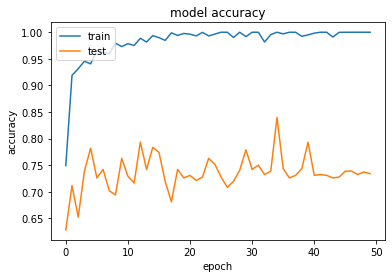

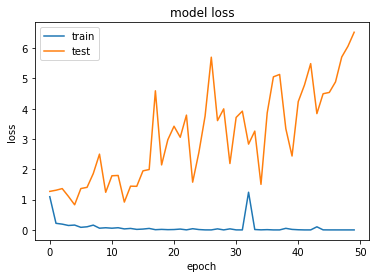

In [16]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Print the Evaluation metrics
prediction= model_two.predict_classes(x_test)
prediction = (model_two.predict(x_test) > 0.5).astype("int32")
print(classification_report(prediction, y_test))

# Print the confusion matrix values
print(confusion_matrix(prediction, y_test))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.31      0.95      0.46        76
           1       0.99      0.70      0.82       548

    accuracy                           0.73       624
   macro avg       0.65      0.83      0.64       624
weighted avg       0.91      0.73      0.78       624

[[ 72   4]
 [162 386]]


### Fourteen-Layer Model

In [18]:
#loading our best performing model

# Source: https://towardsdatascience.com/using-ai-to-detect-pneumonia-3ec4601acd07
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import (Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization)

def get_conv_model_normal():
    
    inp_shape = (128,128,1)
    act = 'relu'
    drop = .5 
    kernal_reg = regularizers.l1(.001)
    dil_rate = 2
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (2,2)))
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid', name = 'Output_Layer'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model 

In [19]:
# Display the loss vs epochs and accuracy vs epochs graphs
model_three = get_conv_model_normal()
history = model_three.fit(datagen.flow(x_train,y_train, batch_size = 32),
                    epochs=50, verbose=1, validation_data = (x_test, y_test))

# convert the history.history dict to a pandas DataFrame:     
hist_three_df = pd.DataFrame(history.history) 
hist_three_df.to_csv('history_three.csv', index=False)

Epoch 1/50
163/163 [==============================] - 137s 832ms/step - loss: 6.9278 - accuracy: 0.7040 - val_loss: 1.4367 - val_accuracy: 0.6250
Epoch 2/50
163/163 [==============================] - 133s 814ms/step - loss: 1.1751 - accuracy: 0.7375 - val_loss: 1.0070 - val_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 134s 819ms/step - loss: 0.8516 - accuracy: 0.7409 - val_loss: 0.8846 - val_accuracy: 0.6250
Epoch 4/50
163/163 [==============================] - 131s 802ms/step - loss: 0.7232 - accuracy: 0.7577 - val_loss: 0.7903 - val_accuracy: 0.6314
Epoch 5/50
163/163 [==============================] - 133s 817ms/step - loss: 0.6804 - accuracy: 0.7914 - val_loss: 0.7080 - val_accuracy: 0.8365
Epoch 6/50
163/163 [==============================] - 133s 817ms/step - loss: 0.7552 - accuracy: 0.8357 - val_loss: 0.8672 - val_accuracy: 0.7356
Epoch 7/50
163/163 [==============================] - 133s 815ms/step - loss: 0.7091 - accuracy: 0.8416 - val_loss: 0.7594 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


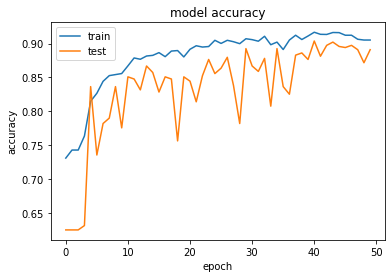

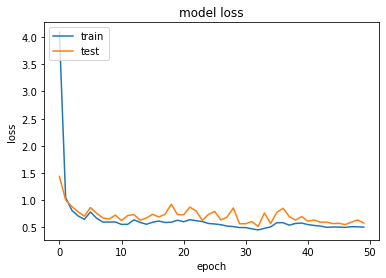

In [20]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# Print the Evaluation metrics
prediction= model_three.predict_classes(x_test)
prediction = (model_three.predict(x_test) > 0.5).astype("int32")
print(classification_report(prediction, y_test))

# Print the confusion matrix values
print(confusion_matrix(prediction, y_test))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.78      0.92      0.84       200
           1       0.96      0.88      0.92       424

    accuracy                           0.89       624
   macro avg       0.87      0.90      0.88       624
weighted avg       0.90      0.89      0.89       624

[[183  17]
 [ 51 373]]
